<a href="https://colab.research.google.com/github/EiffL/Tutorials/blob/master/FoundationModels/AstroCLIPTutorial_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024-2025 Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");

# AstroCLIP Tutorial: Galaxy Similarity Search and Redshift Prediction

Authors:
  - [@EiffL](https://github.com/EiffL) (Francois Lanusse)
  - [@lhparker1](https://github.com/lhparker1) (Liam H. Parker)


In this notebook, we will explore how to use **AstroCLIP**, a cross-modal foundation model trained to embed galaxy images and spectra into a shared, physically meaningful space.

We'll use AstroCLIP to perform two tasks:

- **Similarity Search**: retrieve galaxies that are similar to a given image or spectrum, even across modalities.
- **Redshift Prediction**: train a lightweight prediction model on top of AstroCLIP embeddings to estimate photometric redshifts.

AstroCLIP was trained in a self-supervised way on millions of galaxies from the Legacy Survey, enabling powerful transfer learning without requiring fine-tuning.

---

### 🔍 Learning Objectives

In this notebook, you will learn how to:

- Use a pre-trained cross-modal embedding model for scientific downstream tasks  
- Perform **semantic search** using cosine similarity  
- Train a simple redshift predictor on top of **frozen AstroCLIP embeddings**

---

### ⚙️ Instructions for Enabling GPU Access

By default, notebooks are started without acceleration. To make sure that the runtime is configured for using GPUs, go to `Runtime > Change runtime type`, and select GPU in `Hardware Accelerator`.

---

### Installing dependencies

The install procedure is unfortunately a bit complex, execute the following cell. **Do not restart kernel when prompted**, instead run the cell below.

In [ ]:
# Base install of required utilities
!apt install python3-dev libcairo2-dev pkg-config

# Setting up proper torch version
!pip install --upgrade pip
!pip install lightning[extra]==2.3.3 boto3==1.28.17
!pip install --upgrade pycairo datasets pyarrow
!pip install --extra-index-url https://pypi.nvidia.com cuml-cu11
!pip install --extra-index-url https://download.pytorch.org/whl/cu117 torch==2.0.0+cu117
!pip install torchvision==0.15.0 torchmetrics==0.10.3 dotenv
!pip install numpy==1.26.4 --force-reinstall

# Installing DiNOv2
!pip install omegaconf fvcore iopath
!pip install --no-deps git+https://github.com/facebookresearch/dinov2.git@2302b6bf46953431b969155307b9bed152754069

# Installing AstroCLIP
!pip install astropy datasets huggingface_hub jaxtyping wandb networkx pyvis
!pip uninstall -y transformers
!pip install --no-deps git+https://github.com/PolymathicAI/AstroCLIP.git

In [ ]:
# Restarting kernel after everything is installed
import os
os.kill(os.getpid(), 9)

In [ ]:
# Downloading model weights
!wget -O astroclip.ckpt https://huggingface.co/polymathic-ai/astroclip/resolve/main/astroclip.ckpt?download=true

And finally, run the following cell to setup some utility and plotting functions

In [ ]:
# @title [Run me]
%pylab inline
import pyarrow
pyarrow.PyExtensionType.set_auto_load(True)
from tqdm import tqdm
import networkx as nx
from pyvis.network import Network
from IPython.display import HTML
import base64
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
from IPython.display import display


def graph_from_embeddings(embeddings, images, k=5, symmetrize=True):
    """
    Builds a k-NN graph adjacency matrix using scikit-learn (cosine distance).

    Returns a sparse adjacency matrix (numpy array or CSR).
    """
    # Convert to NumPy and normalize (cosine similarity = dot of L2-normalized vectors)
    emb_np = embeddings.cpu().numpy()

    # scikit-learn uses cosine *distance*, so we negate similarity in behavior
    A = kneighbors_graph(emb_np, n_neighbors=k, metric='cosine', mode='connectivity', include_self=False)

    if symmetrize:
        A = A.maximum(A.T)  # make it symmetric (undirected)

    G = nx.Graph()
    A = A.tocoo()

    for i in range(A.shape[0]):
        G.add_node(i, image_tensor=images[i].permute(1, 2, 0).cpu().numpy() if images is not None else None)

    for i, j, w in zip(A.row, A.col, A.data):
        G.add_edge(i, j, weight=w)

    return G

def encode_image_base64(image_array, scale=1.):
    fig = plt.figure(figsize=(scale, scale), dpi=100)
    plt.axis("off")
    plt.imshow(image_array)
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    return f"data:image/png;base64,{img_base64}"

def draw_interactive_graph_colab(graph):
    net = Network(height='750px', width='100%', bgcolor='#000000', font_color='white', notebook=False, cdn_resources='remote')

    # Encode each image as base64 and use as node icon
    for node_id, data in graph.nodes(data=True):
        img_url = encode_image_base64(data['image_tensor'])
        net.add_node(
            int(node_id),
            shape="image",
            image=img_url,
            title=f"Galaxy {node_id}",
            size=50
        )

    for src, tgt, data in graph.edges(data=True):
        net.add_edge(int(src), int(tgt), value=float(data['weight']) * 5,
                     color='rgba(255, 255, 255, 0.5)')

    # Generate the HTML string (without writing to file)
    html_str = net.generate_html()

    # Display directly in Colab
    return HTML(html_str)


Populating the interactive namespace from numpy and matplotlib


## Accessing data

For this tutorial, we are going to use an already cross-matched compilation of images and spectra, from the Legacy Surveys and DESI respectively.




In [ ]:
import torch
import datasets
from datasets import load_dataset
from torch.utils.data import DataLoader
from astroclip.data.datamodule import AstroClipCollator

In [ ]:
# Loads cross-matched data between DESI and Legacy Survey images
dset = load_dataset('EiffL/AstroCLIP', streaming=True, split='train')
dset = dset.with_format('torch')

# Creates a torch data loader for the data
dloader = DataLoader(dset, batch_size=256,
                      collate_fn=AstroClipCollator(), drop_last=True)
iter_dset = iter(dloader)

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
# We can extract one bach of objects like so:
batch = next(iter_dset)

print(batch.keys())

dict_keys(['image', 'spectrum', 'redshift', 'targetid'])


We see that a batch of object contains an image, a spectrum, a redshift, and a targetid.

Let's visualize a few images:

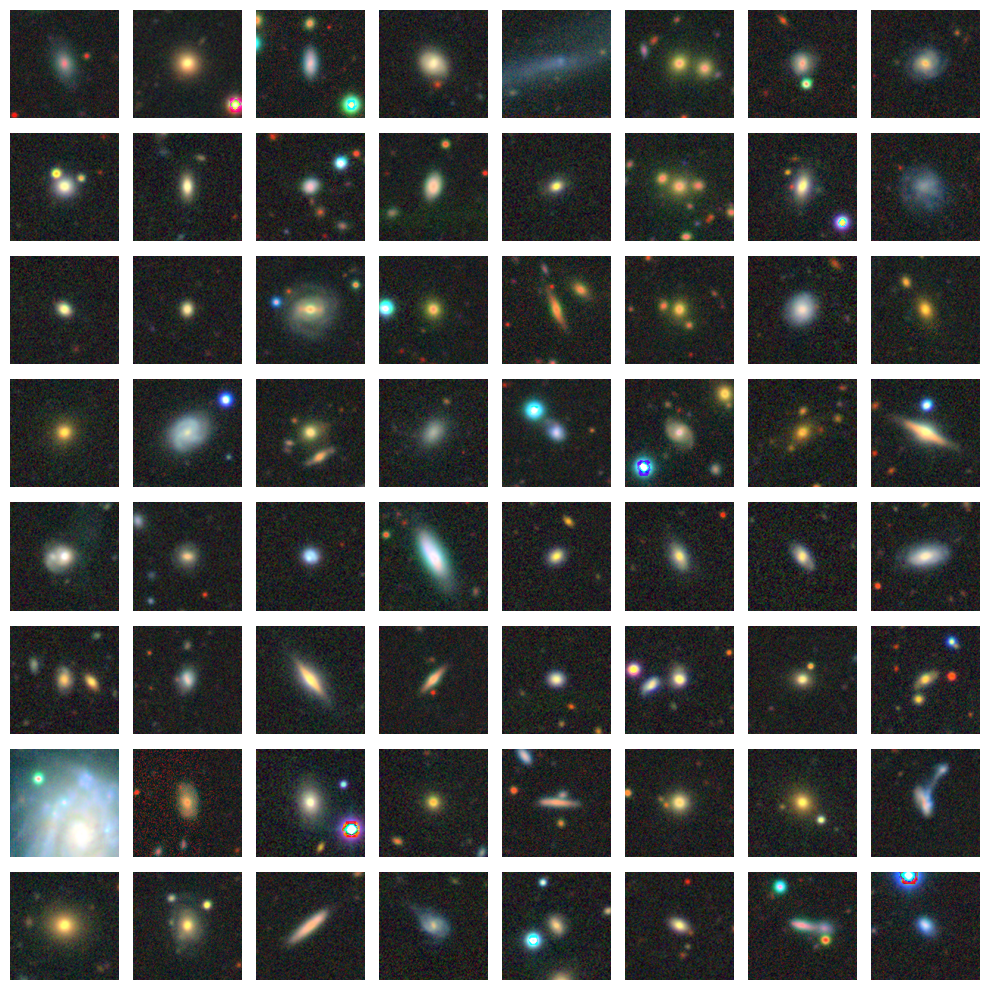

In [ ]:
images = batch['image']

# Assuming images is a tensor of shape (batch_size, channels, height, width)
# and we want to plot the first 64 images in an 8x8 grid.
fig, axes = subplots(8, 8, figsize=(10, 10))
axes = axes.flatten()

for i in range(min(len(images), 64)):
    img = images[i].permute(1, 2, 0).numpy()  # Convert to HWC for matplotlib
    axes[i].imshow(img)
    axes[i].axis('off')

tight_layout()

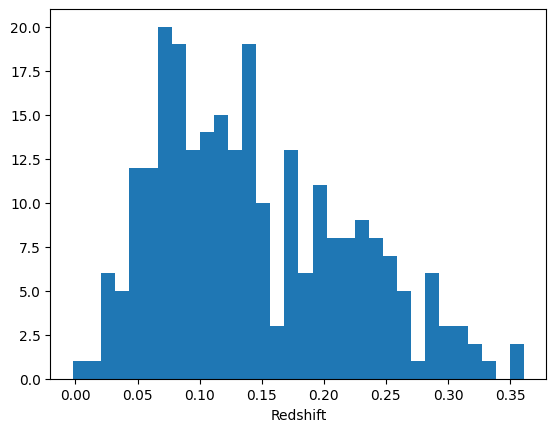

In [ ]:
# And we can also look at the redshifts we get in this batch
z = batch['redshift']
hist(z, bins=32)
xlabel('Redshift');

## Computing embeddings with AstroCLIP

Now that we have seen how to load our data, let's see how to apply the AstroCLIP model.

In [ ]:
from astroclip.models import AstroClipModel

# Loads the model from downloaded checkpoint
model = AstroClipModel.load_from_checkpoint(
    checkpoint_path = "astroclip.ckpt",
).eval()

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'image_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['image_encoder'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'spectrum_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['spectrum_encoder'])`.


In [ ]:
with torch.no_grad():
  # Apply the model on images
  embeddings = model(batch['image'].to('cuda'),
              input_type='image') # AstroCLIP understands 'image' or 'spectum' as input_type

In [ ]:
print(embeddings)
print(embeddings.shape)

tensor([[ 0.1679, -0.2503,  0.0352,  ..., -0.0537,  0.0264, -0.1750],
        [ 0.0083,  0.0727, -0.2131,  ...,  0.0508, -0.0335, -0.2480],
        [ 0.3803, -0.4054,  0.4118,  ...,  0.3244, -0.0903, -0.3390],
        ...,
        [-0.2036,  0.2378, -0.1986,  ..., -0.1239, -0.1958,  0.3617],
        [ 0.2603,  0.0080,  0.0473,  ..., -0.1444, -0.0617, -0.2823],
        [ 0.0987, -0.1069,  0.1296,  ...,  0.0817,  0.4141, -0.0293]],
       device='cuda:0')
torch.Size([256, 1024])


We see that our AstroCLIP model has returned a set of 256 embeddings of size 1024.


Let's look at the structure of that embedding space by adjacency in terms of cosine similarity:


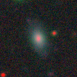
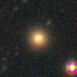
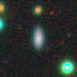
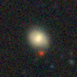
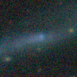
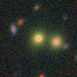
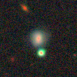
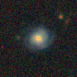
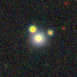
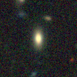
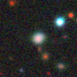
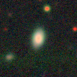
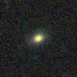
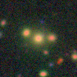
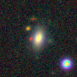
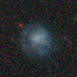
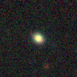
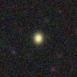
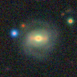
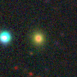
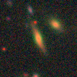
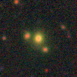
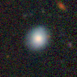
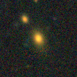
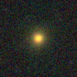
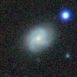
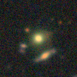
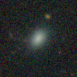
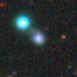
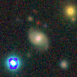
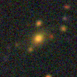
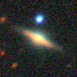
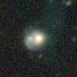
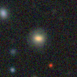
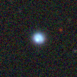
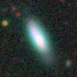
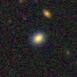
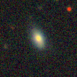
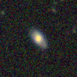
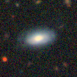
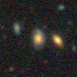
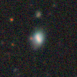
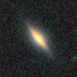
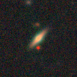
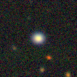
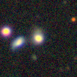
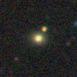
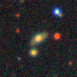
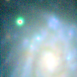
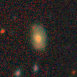
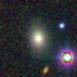
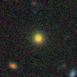
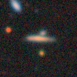
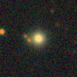
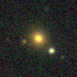
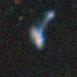
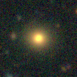
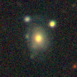
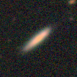
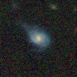
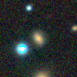
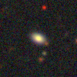
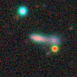
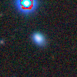
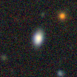
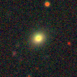
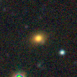
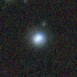
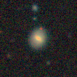
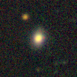
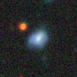
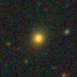
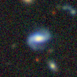
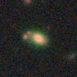
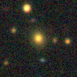
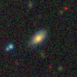
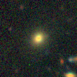
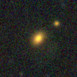
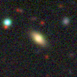
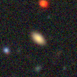
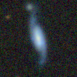
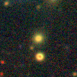
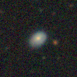
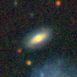
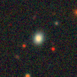
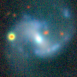
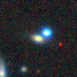
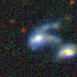
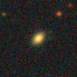
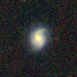
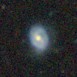
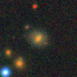
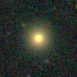
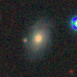
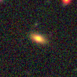
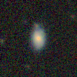
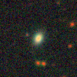
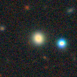
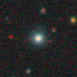
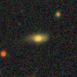
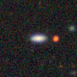
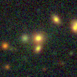
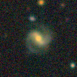
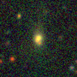
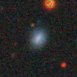
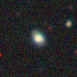
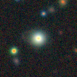
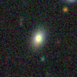
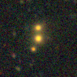
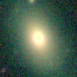
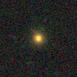
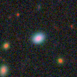
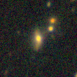
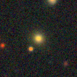
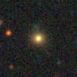
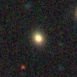
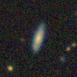
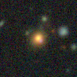
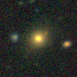
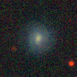
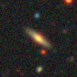
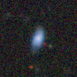
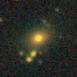
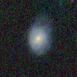
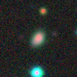
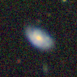
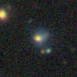
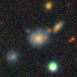
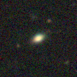
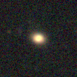
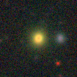
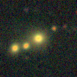
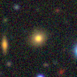
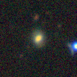
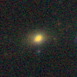
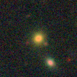
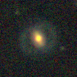
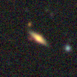
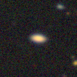
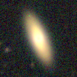
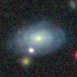
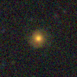
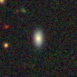
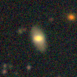
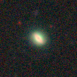
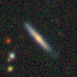
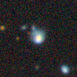
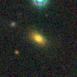
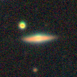
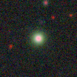
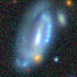
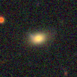
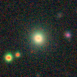
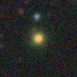
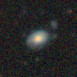
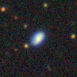
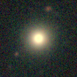
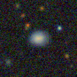
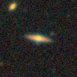
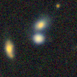
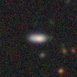
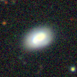
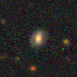
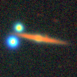
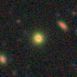
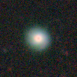
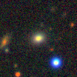
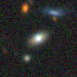
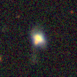
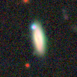
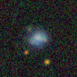
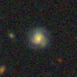
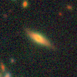
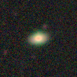
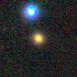
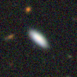
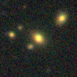
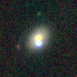
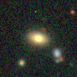
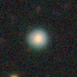
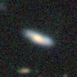
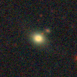
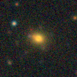
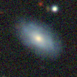
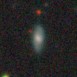
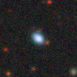
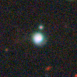
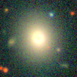
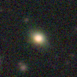
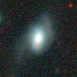
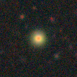
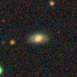
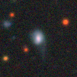
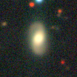
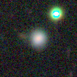
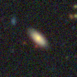
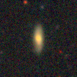
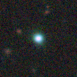
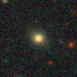
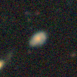
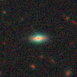
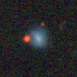
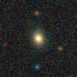
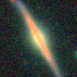
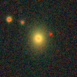
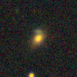
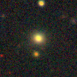
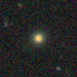
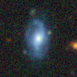
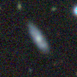
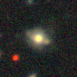
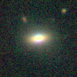
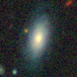
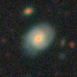
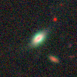
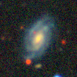
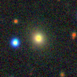
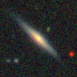
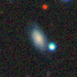
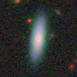
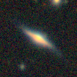
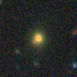
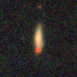
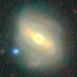
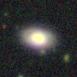
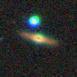
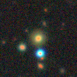
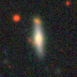
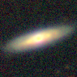
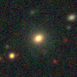
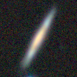
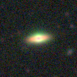
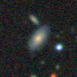
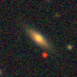
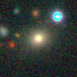
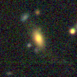
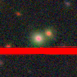
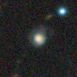
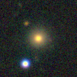
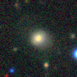
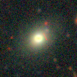
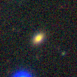
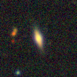
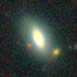
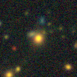
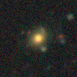
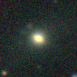
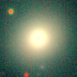
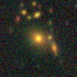
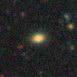
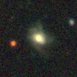
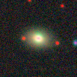
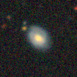
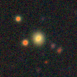
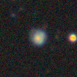
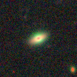

In [ ]:
G = graph_from_embeddings(embeddings, images=images, k=2)
draw_interactive_graph_colab(G)

Now, let's compute systematically embeddings for a large sample of objects.

In [ ]:
embeddings = []
redshift = []
images = []

for i in tqdm(range(20)):
  batch = next(iter_dset)
  with torch.no_grad():
    emb = model(batch['image'].to('cuda'),
              input_type='image').to('cpu')

    images.append(batch['image'].numpy())
    redshift.append(batch['redshift'].numpy())
    embeddings.append(emb.numpy())

embeddings = np.concatenate(embeddings)
redshift = np.concatenate(redshift)
images = np.concatenate(images)

100%|██████████| 20/20 [01:29<00:00,  4.46s/it]


In [ ]:
print(embeddings.shape)

(5120, 1024)


## 🔎 Similarity Search in Embedding Space

In this section, we perform a **similarity search** to find galaxies that are most similar to a selected query image, based on their positions in the learned **embedding space**.

We use **cosine similarity** to measure how close each image embedding is to the embedding of the selected query image. This allows us to identify objects that share similar high-level visual or morphological features, as captured by the embedding model.

The steps are:
- Select a query galaxy image.
- Compute cosine similarity between its embedding and all others in the dataset.
- Retrieve and display the **top 16 most similar images** (excluding the query itself).

This technique enables **fast, content-based retrieval** from large image datasets, and can be a powerful tool for exploratory data analysis and serendipitous discovery.


In [ ]:
query_images = images[:10]
selected_index = {'value': 0}  # Use a mutable dict

# Define the display function
def show_query_image(index):
    selected_index['value'] = index  # Store the selection
    img = query_images[index]
    # Convert CHW to HWC for matplotlib
    img_hwc = np.transpose(img, (1, 2, 0))

    plt.figure(figsize=(3, 3))
    plt.imshow(img_hwc)
    plt.axis('off')
    plt.title(f'Selected Query Image: {index}')
    plt.show()

# Use interact to create a dropdown or slider
interact(show_query_image, index=(0, len(query_images) - 1));

interactive(children=(IntSlider(value=4, description='index', max=9), Output()), _dom_classes=('widget-interac…

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

query_index = selected_index['value']

similarity = cosine_similarity(embeddings[query_index].reshape(1, -1),
                               embeddings).squeeze()

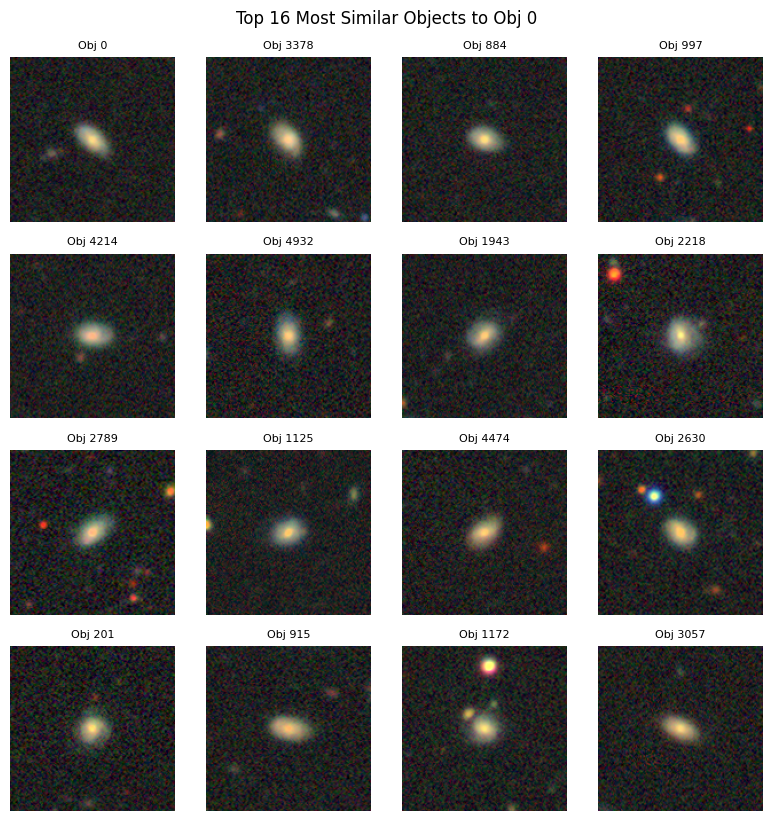

In [ ]:
# Get indices of all embeddings
all_indices = np.arange(len(embeddings))
# Sort by similarity in descending order
sorted_indices = all_indices[np.argsort(similarity)[::-1]]

# Exclude the query index if it's among the top results
# We want the top 16 *other* objects
top_n = 16
top_indices = sorted_indices[:top_n]

# Retrieve the images corresponding to these top indices
top_images = images[top_indices]

# Draw the postage stamps
fig, axes = subplots(4, 4, figsize=(8, 8)) # Create a 4x4 grid for 16 images
axes = axes.flatten()

for i in range(min(len(top_images), 16)):
    img = top_images[i]
    # Convert CHW to HWC for matplotlib
    img_hwc = np.transpose(img, (1, 2, 0))
    axes[i].imshow(img_hwc)
    axes[i].axis('off')
    # Optional: Add title indicating the index of the retrieved image in the original dataset
    axes[i].set_title(f'Obj {top_indices[i]}', fontsize=8)

tight_layout()
plt.suptitle(f'Top {top_n} Most Similar Objects to Obj {query_index}', y=1.02)
plt.show()


## 📈 Redshift Estimation with k-Nearest Neighbors (k-NN) Regression

In this section, we use a **k-Nearest Neighbors (k-NN) regressor** to predict galaxy redshifts directly from their image embeddings.

The idea is simple: for a given embedding, find its `k` closest neighbors in the embedding space and return the **average redshift** of those neighbors. This method relies on the assumption that similar embeddings (i.e., similar galaxies) should have similar redshifts.

Here’s what we do:
- Split the dataset into training and testing sets.
- Train a `KNeighborsRegressor` using the training embeddings and redshifts.
- Predict redshifts for the test set.
- Visualize the performance by plotting **true vs. predicted redshifts**.

This provides a quick baseline and helps assess how well the learned embedding space captures redshift-related information.


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Prepare data for k-NN regression
X_train, X_test, y_train, y_test = train_test_split(embeddings, redshift, test_size=0.2, random_state=42)

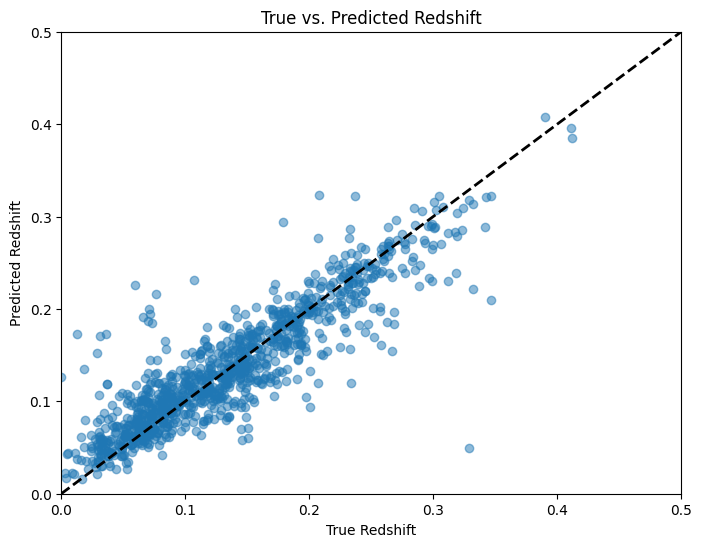

In [ ]:
# TODO: create a KNeighborsRegressor with n_neighbors 10
# and fit it to the train data
# See documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

knn_regressor = KNeighborsRegressor(n_neighbors=10)
knn_regressor.fit(X_train, y_train)

# Predict redshift on the test set
y_pred = knn_regressor.predict(X_test)

# Plot true vs predicted redshift (optional)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Redshift")
plt.ylabel("Predicted Redshift")
plt.title(f"True vs. Predicted Redshift")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Add a diagonal line
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.show()

## 🔍 Inferring Redshifts with Implicit Inference

In this section, we use Implicit Inference to model the conditional distribution of galaxy redshift given an image embedding. Specifically, we apply the **Sequential Neural Posterior Estimation (SNPE-A)** algorithm from the `sbi` library.

Rather than predicting a single redshift value, this approach learns the full **posterior distribution** \( p(\text{redshift} \mid \text{embedding}) \), capturing uncertainty and potential ambiguities in the mapping from image features to physical properties.

Here's what we do:
- Treat our training set of embeddings (`X_train`) and corresponding redshifts (`y_train`) as observed simulations.
- Define a simple prior over redshift values (uniform between 0 and 1).
- Use SNPE-A to train a neural density estimator that approximates the posterior over redshift given a new embedding.

This allows us to move beyond point estimates and toward **probabilistic reasoning**, providing more informative outputs for downstream scientific analysis.


In [ ]:
!pip install sbi

In [ ]:
from sbi.inference import SNPE_A
from sbi.utils import BoxUniform
from torch import Tensor

# Setting up the training data
x_obs = torch.tensor(X_train, dtype=torch.float32)
theta_obs = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # sbi expects parameter tensors to have shape (num_samples, num_parameters)

# Define a simple prior for the redshift. Assuming redshifts are between 0 and 1 for simplicity.
# In a real scenario, you'd define a prior that reflects your knowledge about the redshift distribution.
prior = BoxUniform(low=torch.zeros(1), high=torch.ones(1))

# Building the inference method
inference = SNPE_A(prior=prior)
inference.append_simulations(theta_obs, x_obs)

# Train the posterior estimator
# This step trains the neural network to learn p(theta | x) based on the provided data.
print("Training the SBI posterior estimator...")
density_estimator = inference.train()
print("Training complete.")

Training the SBI posterior estimator...
 Neural network successfully converged after 41 epochs.Training complete.



Estimating posterior for a test sample...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

True redshift for this sample: 0.0839
Posterior mean redshift estimate: 0.0807


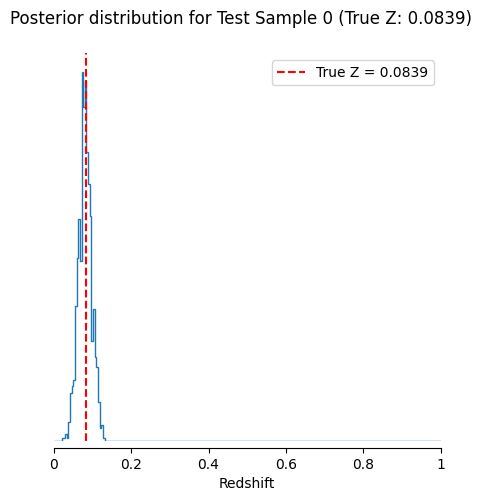

In [ ]:
from sbi.analysis import pairplot

# Now we can use the trained density estimator to estimate the posterior distribution of redshift
# for new observations (embeddings) in the test set X_test.

# Convert X_test to tensor
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Estimate the posterior distribution for the first test sample
# You can loop through the test set or process in batches
print("\nEstimating posterior for a test sample...")
# Let's pick the first sample from the test set
test_sample_embedding = x_test_tensor[0].unsqueeze(0) # Add batch dimension

# Get the posterior object for this observation
posterior = inference.build_posterior(density_estimator=density_estimator)

# Sample from the posterior distribution for this observation
num_samples = 1000
posterior_samples = posterior.sample(sample_shape=(num_samples,), x=test_sample_embedding)

print(f"True redshift for this sample: {y_test[0]:.4f}")
# Calculate the mean of the posterior samples as a point estimate
predicted_redshift_mean = posterior_samples.mean().item()
print(f"Posterior mean redshift estimate: {predicted_redshift_mean:.4f}")

# Let's plot the posterior for the first test sample again
fig, axes = pairplot(posterior_samples, limits=[[0, 1]], labels=['Redshift'], figsize=(5,5))
plt.suptitle(f"Posterior distribution for Test Sample 0 (True Z: {y_test[0]:.4f})")

# Overlay the true redshift as a vertical line
true_z = y_test[0]
axes.axvline(true_z, color='red', linestyle='--', label=f'True Z = {true_z:.4f}')
axes.legend()

plt.show();